## Notebook to process LAU and NUTS shapefile to parquet

In [2]:
# Load software
import os
import pathlib
import sys
import json
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from dotenv import load_dotenv
import math
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
import rioxarray as rio

# Import custom functionality
from coclicodata.drive_config import p_drive

# Define (local and) remote drives
coclico_data_dir = p_drive.joinpath("11207608-coclico", "FASTTRACK_DATA")

C:\Users\soest\AppData\Local\Temp\ipykernel_7156\2233362837.py:7: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [11]:
# Set path to geopackage
LAU_dir = coclico_data_dir.joinpath('XX_LAU')
NUTS_dir = coclico_data_dir.joinpath('XX_NUTS')

LAU_file = LAU_dir.joinpath('LAU_RG_01M_2020_3035.shp')

# Load data
LAU = gpd.read_file(LAU_file) # takes a while! Order of 15 minutes

In [12]:
LAU

,GISCO_ID,CNTR_CODE,LAU_ID,LAU_NAME,POP_2020,POP_DENS_2,AREA_KM2,YEAR,FID,geometry
0,CZ_579475,CZ,579475,Libňatov,363.0,62.240158,5.832247,2020,CZ_579475,"POLYGON ((4747705.585 3057545.260, 4746836.524..."
1,CZ_579483,CZ,579483,Libotov,178.0,41.774759,4.260946,2020,CZ_579483,"POLYGON ((4731662.418 3049054.578, 4732297.093..."
2,CZ_579491,CZ,579491,Vranov,181.0,37.408873,4.838424,2020,CZ_579491,"POLYGON ((4540137.623 2963864.496, 4538706.113..."
3,CZ_579505,CZ,579505,Malá Úpa,142.0,5.318510,26.699207,2020,CZ_579505,"POLYGON ((4730399.261 3087673.334, 4730914.253..."
4,AT_41004,AT,41004,Eggendorf im Traunkreis,1041.0,116.481747,8.937023,2020,AT_41004,"POLYGON ((4631543.792 2788412.230, 4630476.583..."
...,...,...,...,...,...,...,...,...,...,...
98608,SK_599816,SK,599816,Košice - mestská časť Nad jazerom,24443.0,6686.211551,3.655732,2020,SK_599816,"POLYGON ((5149120.507 2905279.350, 5150154.014..."
98609,SK_599824,SK,599824,Košice - mestská časť Juh,22692.0,2324.881955,9.760496,2020,SK_599824,"POLYGON ((5144451.048 2904986.166, 5144591.047..."
98610,SK_599841,SK,599841,Košice - mestská časť Šaca,5969.0,124.672777,47.877333,2020,SK_599841,"POLYGON ((5141041.890 2900350.394, 5144604.564..."
98611,SK_599859,SK,599859,Košice - mestská časť Poľov,1219.0,94.049511,12.961258,2020,SK_599859,"POLYGON ((5141041.890 2900350.394, 5141299.765..."


In [13]:
# Write data as parquet file
lau_parquet_file = str(LAU_file).replace('.shp','.parquet')
LAU.to_parquet(lau_parquet_file)

In [14]:
# Test new parquet file
test_parquet = pd.read_parquet(lau_parquet_file)
test_parquet

,GISCO_ID,CNTR_CODE,LAU_ID,LAU_NAME,POP_2020,POP_DENS_2,AREA_KM2,YEAR,FID,geometry
0,CZ_579475,CZ,579475,Libňatov,363.0,62.240158,5.832247,2020,CZ_579475,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0b\x00...
1,CZ_579483,CZ,579483,Libotov,178.0,41.774759,4.260946,2020,CZ_579483,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00...
2,CZ_579491,CZ,579491,Vranov,181.0,37.408873,4.838424,2020,CZ_579491,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x...
3,CZ_579505,CZ,579505,Malá Úpa,142.0,5.318510,26.699207,2020,CZ_579505,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x17\x00...
4,AT_41004,AT,41004,Eggendorf im Traunkreis,1041.0,116.481747,8.937023,2020,AT_41004,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0b\x00..."
...,...,...,...,...,...,...,...,...,...,...
98608,SK_599816,SK,599816,Košice - mestská časť Nad jazerom,24443.0,6686.211551,3.655732,2020,SK_599816,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x..."
98609,SK_599824,SK,599824,Košice - mestská časť Juh,22692.0,2324.881955,9.760496,2020,SK_599824,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00...
98610,SK_599841,SK,599841,Košice - mestská časť Šaca,5969.0,124.672777,47.877333,2020,SK_599841,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1d\x00...
98611,SK_599859,SK,599859,Košice - mestská časť Poľov,1219.0,94.049511,12.961258,2020,SK_599859,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0e\x00...


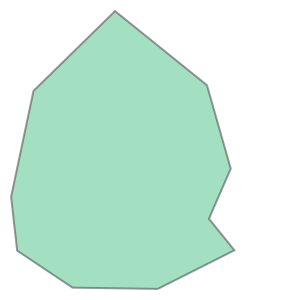

In [18]:
import shapely
shapely.Polygon(LAU.geometry[0])